## Sumbit example

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [61]:
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

In [62]:
data = pd.read_csv('train.csv')
data.head()


,Unnamed: 0,category,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,date_of_registration
0,6622,ecom,6488536.0,NaN,0,82221,0,0,18.450527,0.461750,2020-04-21 16:04:41.817367072
1,2047,information_source,874840.0,21100.0,0,12872,0,0,10.721619,-0.022317,2024-07-19 23:50:07.268931816
2,1118,information_source,571210.0,94707.0,0,0,7420,0,1.922243,0.046396,2024-07-13 16:35:54.794883135
3,4992,news,89534.0,924.0,0,834,0,0,2.149243,-0.093360,2024-09-10 21:29:14.006315095
4,9970,information_source,1043953.0,289288.0,0,58375,20260,3948,3.764965,0.027303,2024-05-26 11:07:15.950527838


In [63]:
data.describe()

,Unnamed: 0,clicks,likes,buys,4xx_errors,5xx_errors,average_dwelltime,source_attractiveness
count,8000.000000,7.727000e+03,7.624000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8000.000000,8000.000000
mean,5006.138875,2.749785e+06,5.985027e+05,5.810509e+05,8.204958e+04,2.769224e+04,6.979549,0.191997
std,2893.886162,4.699120e+06,1.978345e+06,2.262221e+06,1.555219e+05,7.946935e+04,10.004924,0.227873
min,0.000000,5.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,-0.681718
25%,2493.250000,3.599210e+05,0.000000e+00,0.000000e+00,2.943000e+03,0.000000e+00,1.503928,0.038220
50%,5035.000000,1.097221e+06,3.399550e+04,0.000000e+00,2.671750e+04,0.000000e+00,4.022802,0.154256
75%,7521.250000,2.915358e+06,2.860638e+05,0.000000e+00,9.500225e+04,2.016375e+04,8.899400,0.282510
max,9999.000000,6.203206e+07,5.582181e+07,4.277391e+07,2.904996e+06,1.865588e+06,211.218066,1.355736


Видим, что датасет не нормализован

In [64]:
categories = data['category'].unique()
data_categories = data.groupby('category')['source_attractiveness'].max()
print(categories, data_categories)

['ecom' 'information_source' 'news' 'porn' 'social'] category
ecom                  1.355736
information_source    0.578475
news                  0.458114
porn                  0.468389
social                0.507590
Name: source_attractiveness, dtype: float64


Почему-то максимальное значение в еком больше 1...


In [65]:
data['complaints_count'] = pd.to_numeric(data['complaints_count'], errors='coerce')

приводим все значения из *complaints_count* к числовым

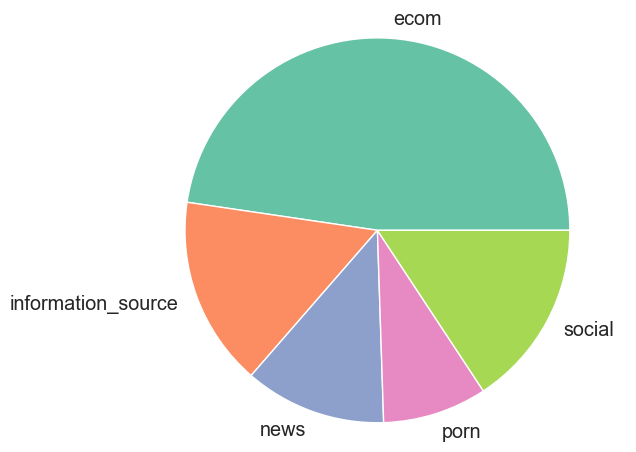

In [66]:
labels = np.unique(data['category'])

vals = data.groupby('category')['source_attractiveness'].mean()

fig, ax = plt.subplots()
ax.pie(vals, labels=labels)
ax.axis("equal")
plt.tight_layout()

график показывает, что самая большая средняя оценка по сервисам у категории *ecom*

<Axes: >

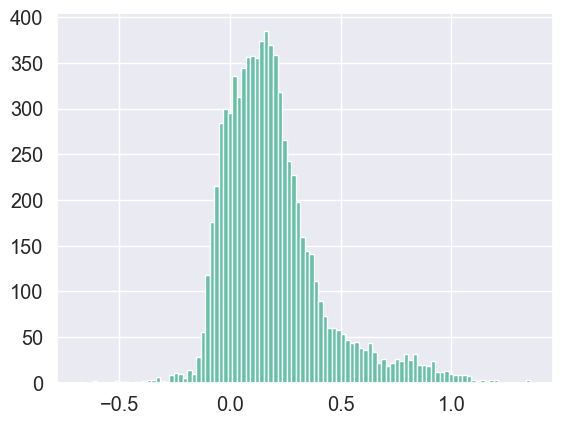

In [67]:
data['source_attractiveness'].hist(bins=100)

Распределение таргета достаточно узкое. Практически все значения расположены в промежутке между -0.2 и 1

In [68]:
def print_shape(data):
    shape = data.shape
    print("Rows:", shape[0])
    print("Cols:", shape[1])

print_shape(data)

Rows: 8000
Cols: 11


In [69]:
train, test = train_test_split(data, test_size=0.2)

print_shape(train)

print_shape(test)

Rows: 6400
Cols: 11
Rows: 1600
Cols: 11


делим выборку на train и test

In [70]:
train['date_of_registration'] = pd.to_datetime(train['date_of_registration'], errors='coerce')

train['time_of_work'] = ((datetime.now() - train['date_of_registration']) / pd.Timedelta(days=365))

test['date_of_registration'] = pd.to_datetime(test['date_of_registration'], errors='coerce')

test['time_of_work'] = ((datetime.now() - test['date_of_registration']) / pd.Timedelta(days=365))


Вводим столбец со значением, показывающим время работы домена. Делаем года int значениями, чтоб в последствии сделать из них категориальный признак.

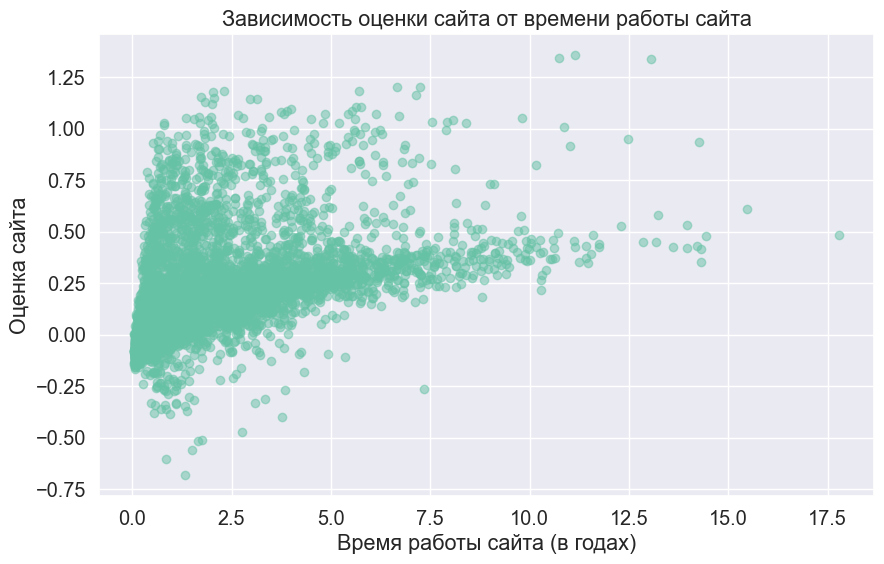

In [71]:
plt.figure(figsize=(10, 6))
plt.scatter(train['time_of_work'], train['source_attractiveness'], alpha=0.5)
plt.title('Зависимость оценки сайта от времени работы сайта')
plt.xlabel('Время работы сайта (в годах)')
plt.ylabel('Оценка сайта')
plt.grid(True)
plt.show()

Сайты, которые работают достаточно длительное время не получают низких оценок

<Axes: >

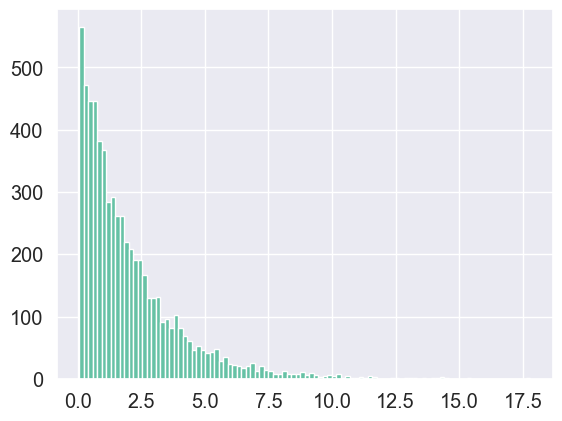

In [72]:
train['time_of_work'].hist(bins=100)

Большинство доменов работаю не сильно продолжительное время

In [73]:
train['time_of_work'] = train['time_of_work'].astype(int)

test['time_of_work'] = test['time_of_work'].astype(int)

приводим к int значению, чтобы использовать как категориальную переменную

In [74]:
categorial_features = ['category', 'time_of_work']  
real_features = ['clicks', 'likes', 'buys', '4xx_errors', '5xx_errors', 'complaints_count', 'average_dwelltime'] 
target_features = 'source_attractiveness'  


In [75]:
import warnings
warnings.filterwarnings('ignore')

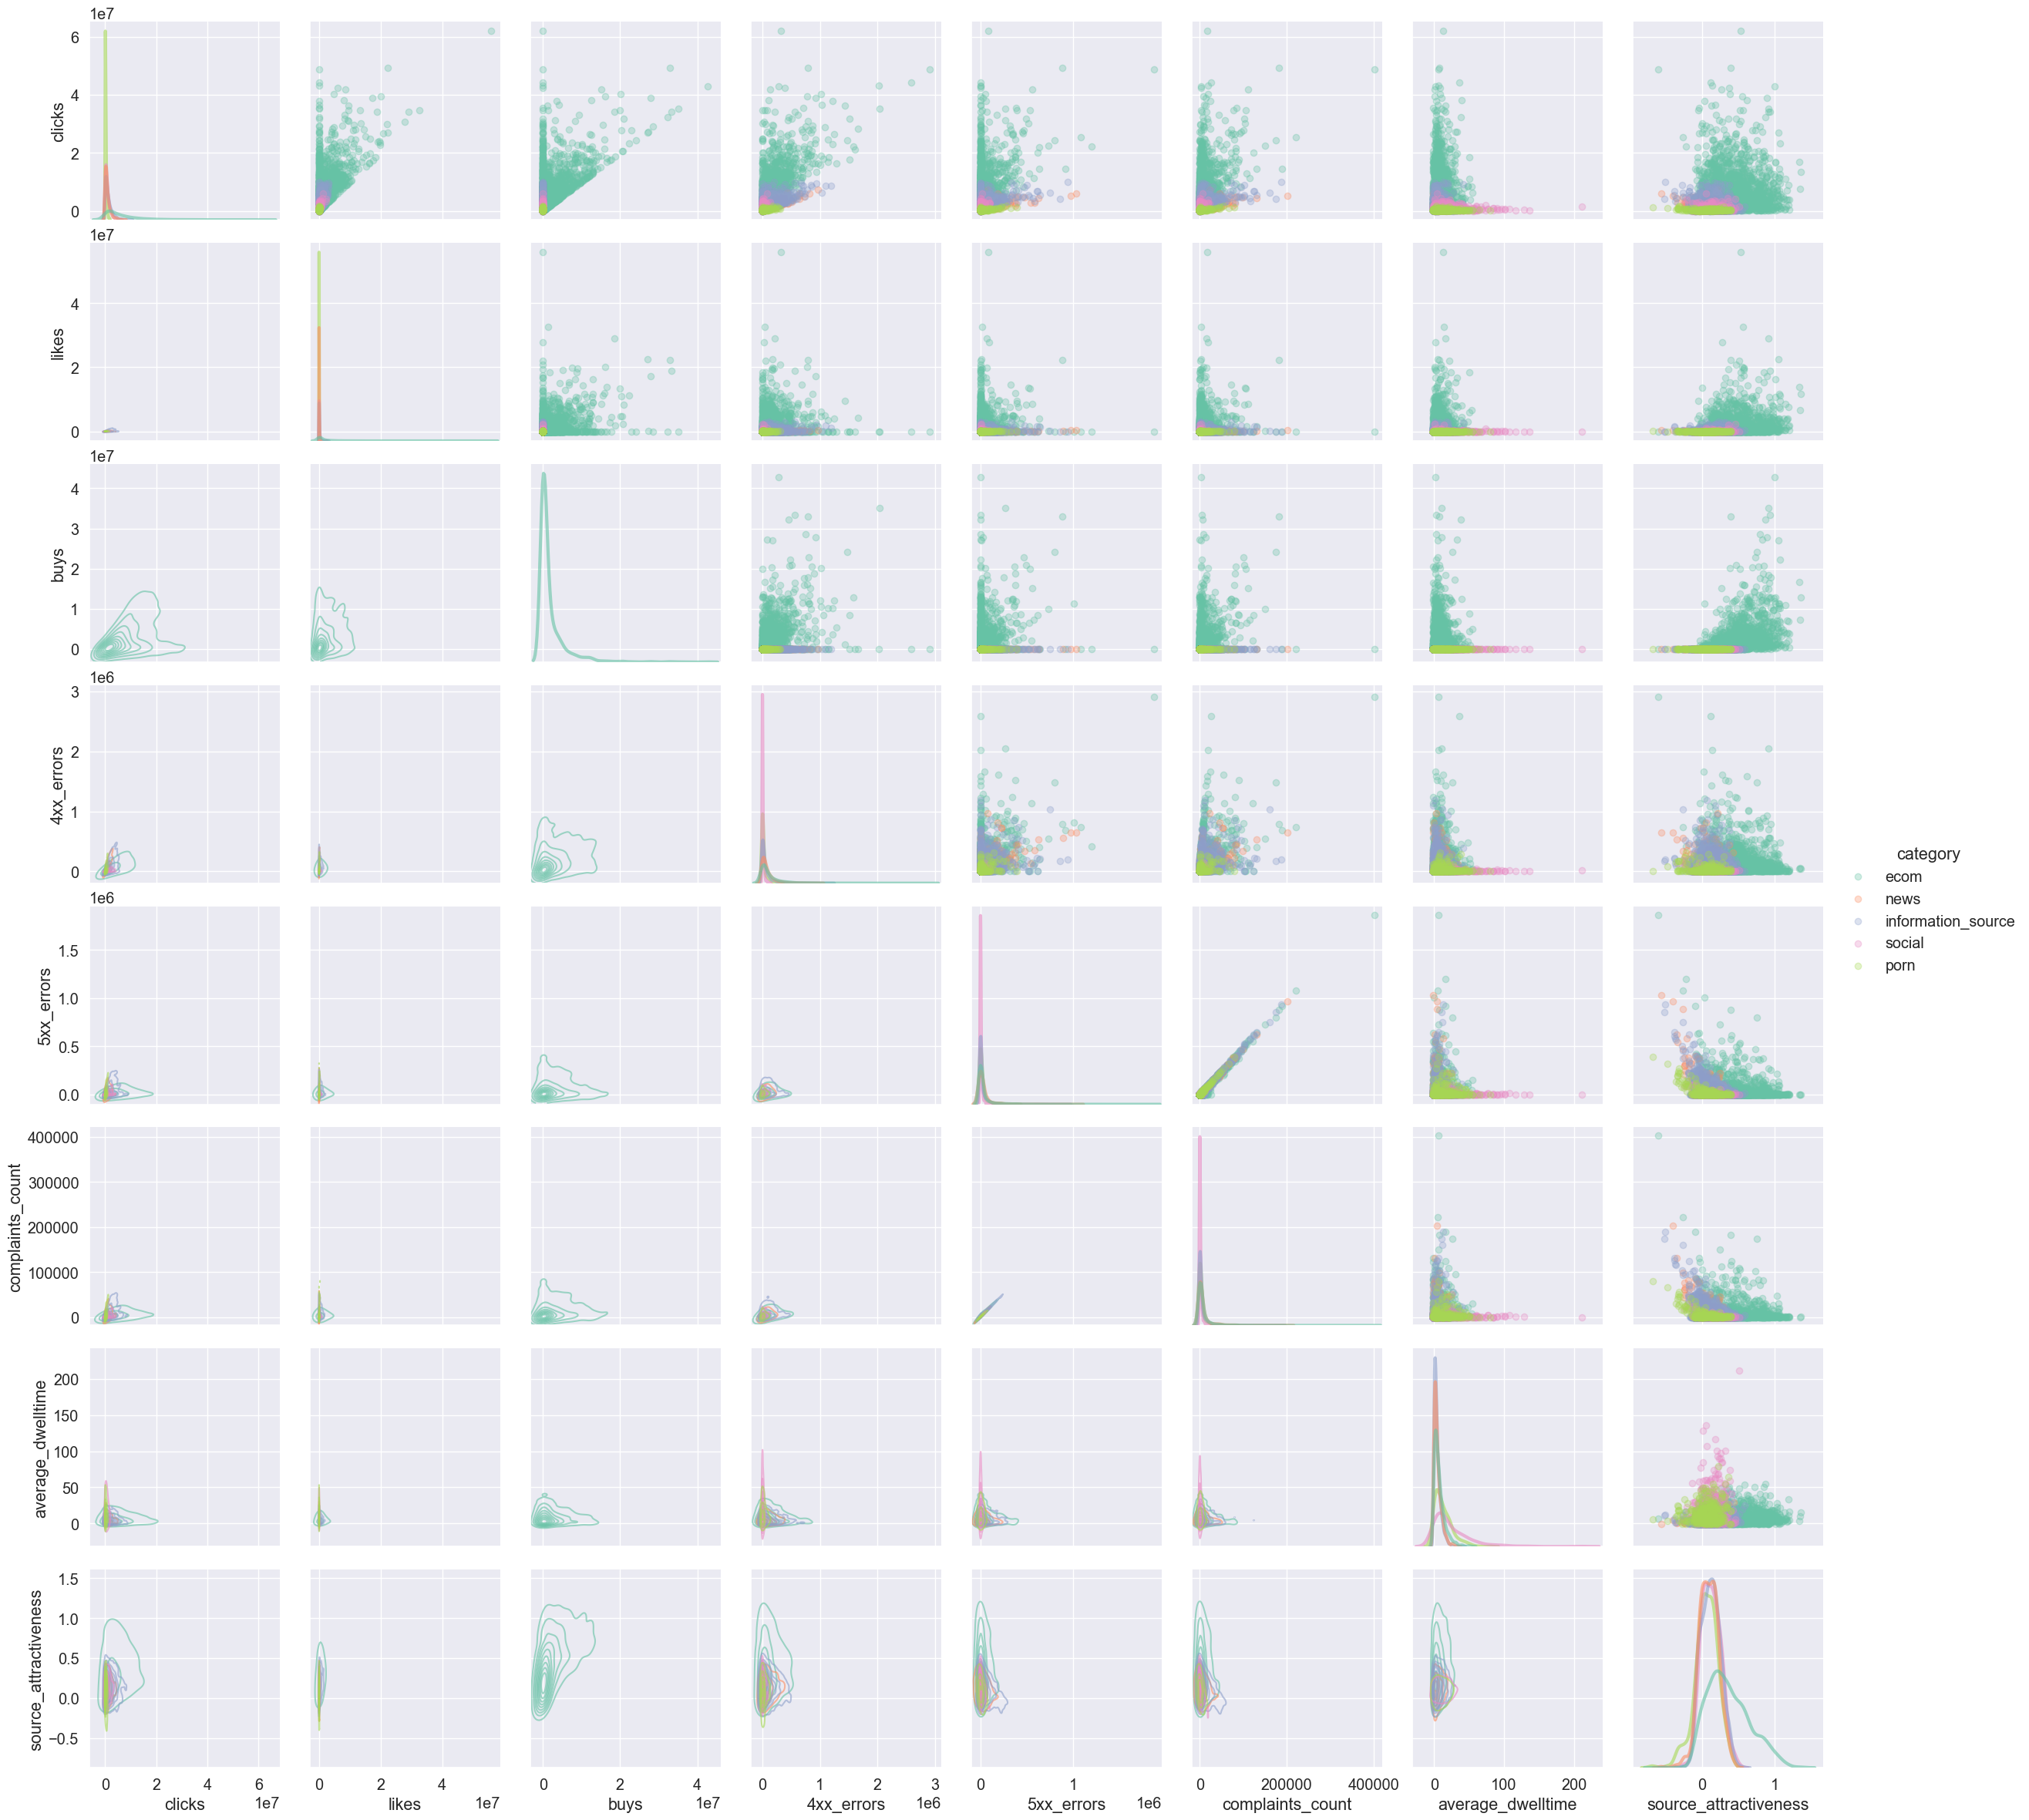

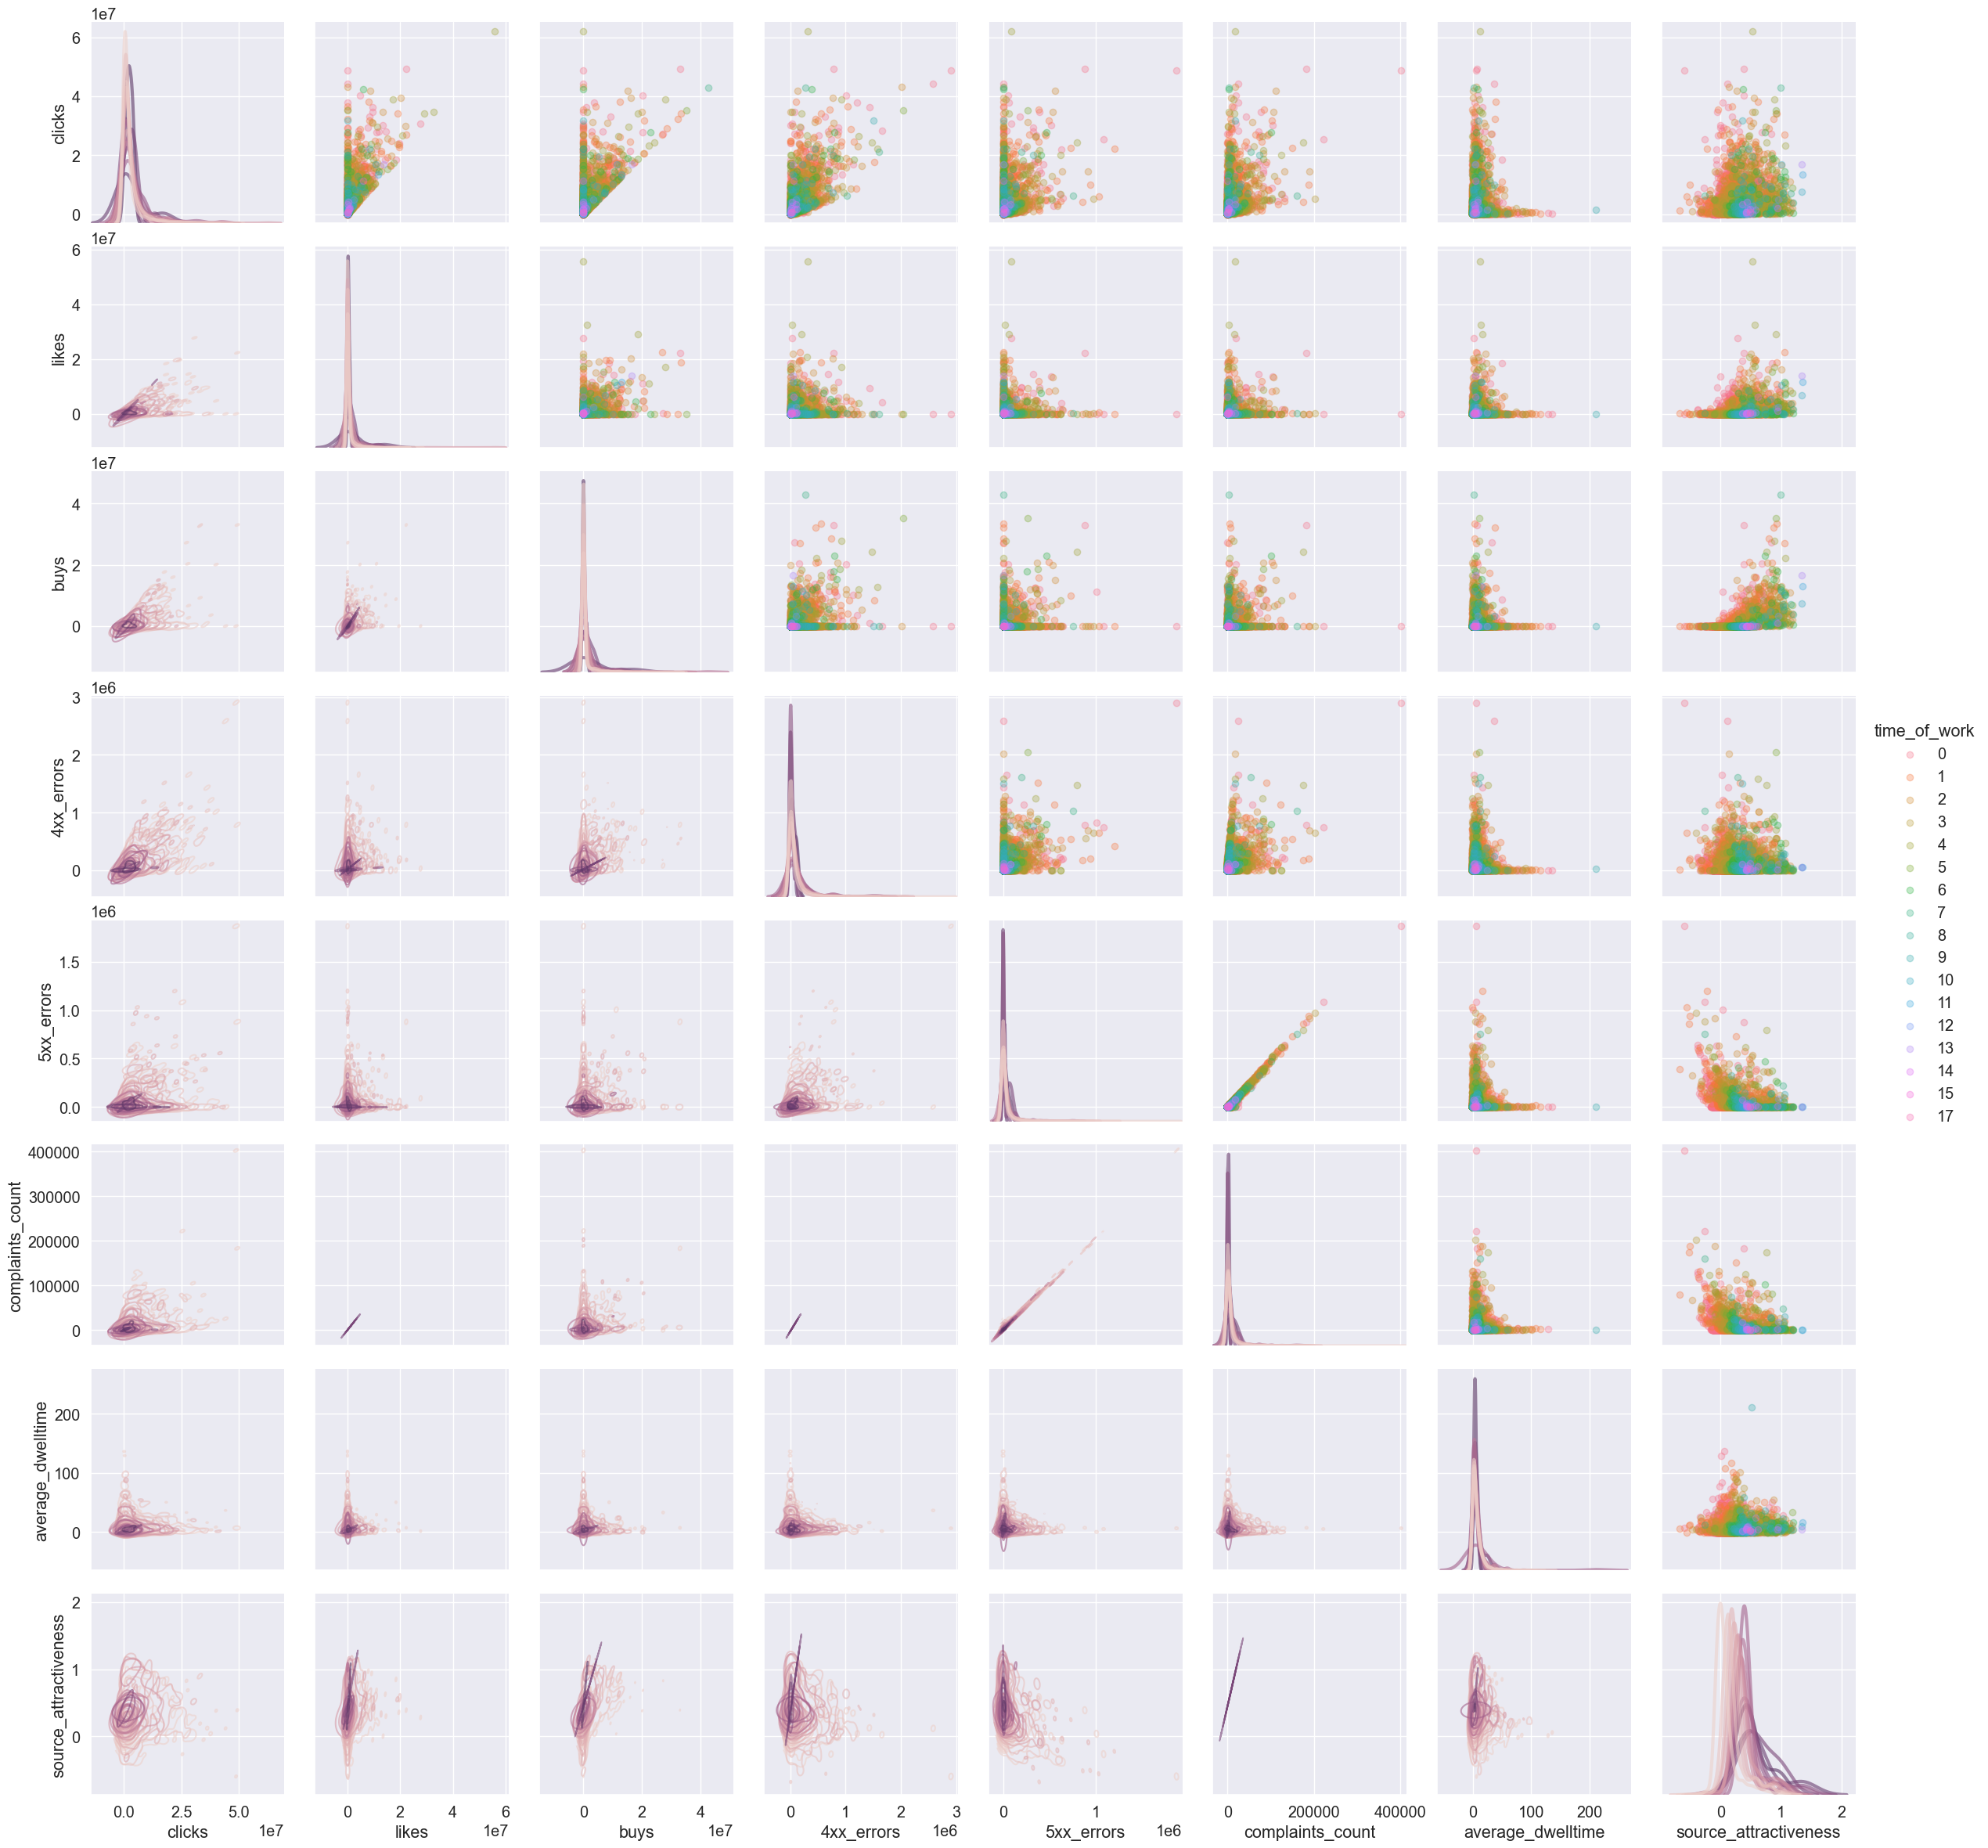

In [76]:
for hue in categorial_features:
    g = sns.PairGrid(train[[*(real_features + [target_features]), hue]], hue=hue, diag_sharey=False, height=3)
    g.map_lower(sns.kdeplot, alpha=0.6)
    g.map_upper(plt.scatter, alpha=0.3)
    g.map_diag(sns.kdeplot, lw=3, alpha=0.6, common_norm=False)
    g.add_legend()

похоже таргер сильно зависит от количества покупок, а также лайков у домена. Также заметно, что оценка у *ecom* намного лучше, чем у других категорий. Можно заметить, что 5xxerrors и complaints_count практически линейны, так что откажемся от одного из этих столбцов.

In [77]:
real_features = ['clicks', 'likes', 'buys', '4xx_errors', 'complaints_count', 'average_dwelltime'] 

In [91]:
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
train_cat = encoder.fit_transform(train[categorial_features])
train_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [92]:
encoder.categories_

[array(['ecom', 'information_source', 'news', 'porn', 'social'],
       dtype=object),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17])]

In [93]:
train[target_features] = pd.to_numeric(train[target_features], errors='coerce')
train[real_features] = train[real_features].apply(pd.to_numeric, errors='coerce')

train[target_features] = train[target_features].fillna(train[target_features].mean())
train[real_features] = train[real_features].fillna(train[real_features].mean())

test[target_features] = test[target_features].fillna(test[target_features].mean())
test[real_features] = test[real_features].fillna(test[real_features].mean())

Снова приводим все к числовым значениям, а также заменяем NaN значения на среднее

In [94]:
X_train = np.hstack([train[real_features].values, train_cat])
print_shape(X_train)

Rows: 6400
Cols: 26


In [95]:
model = LinearRegression(fit_intercept=True)
model.fit(X_train, train[target_features])

LinearRegression()

In [96]:
model.coef_

array([-1.36867063e-08,  2.02524018e-08,  4.57996269e-08,  2.16268939e-08,
       -2.69088861e-06,  1.92808360e-03, -2.00851499e-01, -2.26951750e-01,
       -2.83277325e-01, -2.47698322e-01,  1.32877038e-01,  1.91965434e-01,
        2.41560099e-01,  2.69221553e-01,  3.06422977e-01,  3.28767217e-01,
        3.49513159e-01,  3.55422278e-01,  3.66764428e-01,  3.99925154e-01,
        4.38842207e-01,  4.73413444e-01,  4.36972408e-01,  4.89758580e-01,
        4.20836204e-01,  4.69749249e-01])

In [97]:
model.intercept_

np.float64(0.21406177071520277)

In [98]:
test_cat = encoder.transform(test[categorial_features])
X_test = np.hstack([test[real_features], test_cat])

In [99]:
test_preds = model.predict(X_test)

In [100]:
MSE = ((test[target_features] - test_preds) ** 2).mean()
np.sqrt(MSE)

np.float64(0.11740877002476963)

# **результаты линейной регрессии**

In [101]:
metrics.mean_squared_error(test[target_features], test_preds, squared=True),\
metrics.mean_absolute_error(test[target_features], test_preds),\
metrics.mean_absolute_percentage_error(test[target_features], test_preds) * 100,\
metrics.r2_score(test[target_features], test_preds)

(np.float64(0.013784819278729241),
 np.float64(0.08176648273824327),
 np.float64(227.85739739360213),
 0.7199553542031678)

In [102]:
train_preds = model.predict(X_train)

metrics.mean_squared_error(train[target_features], train_preds, squared=True), \
metrics.mean_absolute_error(train[target_features], train_preds), \
metrics.mean_absolute_percentage_error(train[target_features], train_preds) * 100,\
metrics.r2_score(train[target_features], train_preds)

(np.float64(0.015379940186645649),
 np.float64(0.08446760589556139),
 np.float64(205.2780732241233),
 0.7075295417284067)